# Reaction-network: Network (Demo Notebook)

### <u> Author:</u> Matthew McDermott (Lawerence Berkeley National Laboratory)

Last Updated: 10/20/22

The code provided in this notebook is an updated walkthrough of the first example (modeling YMnO$_3$ synthesis) in the manuscript cited below. The refactored `reaction-network` package contains similar code to what was originally released with the manuscript; however, many processes/functions are now separated into their own defined classes/methods. For a look at the previous demo notebook (which also contained some of the raw results that went into the manuscript), please check out the _archived_ folder.

**If you use this code or Python package in your work, please consider citing the following paper:**

    McDermott, M. J., Dwaraknath, S. S., and Persson, K. A. (2021). A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis. Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-23339-x

### Imports

In [1]:
import logging 

from monty.serialization import loadfn
from mp_api.client import MPRester
from pymatgen.core.composition import Element
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

from rxn_network.core.composition import Composition
from rxn_network.costs.softplus import Softplus
from rxn_network.thermo.chempot_diagram import ChemicalPotentialDiagram
from rxn_network.entries.entry_set import GibbsEntrySet
from rxn_network.enumerators.basic import BasicEnumerator, BasicOpenEnumerator
from rxn_network.enumerators.minimize import MinimizeGibbsEnumerator, MinimizeGrandPotentialEnumerator
from rxn_network.network.network import ReactionNetwork
from rxn_network.entries.nist import NISTReferenceEntry
from rxn_network.reactions.computed import ComputedReaction
from rxn_network.reactions.reaction_set import ReactionSet
from rxn_network.reactions.open import OpenComputedReaction
from rxn_network.network.entry import NetworkEntry, NetworkEntryType
from rxn_network.network.visualize import plot_network_on_graphistry, plot_network
from rxn_network.pathways.solver import PathwaySolver

#import graphistry

/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/pymatgen/analysis/phase_diagram.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%load_ext autoreload
%autoreload 2

## Case Study: YMnO3 assisted metathesis

We will be using the assisted metathesis synthesis of YMnO3 as a case study for the reaction network code. This is the first example discussed in the original manuscript. The assisted metathesis reaction reported by Todd & Neilson (JACS, 2019) corresponds to a net reaction equation:

$$ Mn_2O_3 + 2 YCl_3 + 3Li_2CO_3 \to 2YMnO_3 + 6LiCl + 3CO_2 $$

In the paper, they report a reaction pathway involving the formation of intermediates LiMnO2 and YOCl. These react to form YMnO3 product and LiCl byproduct. (The CO2 is released when Li2CO3 reacts initially to form LiMnO2).

### Downloading and modifying entries

First, we acquire entries for phases in the Y-Mn-O-Li-Cl-C chemical system from the Materials Project (MP), a computed materials database containing calculations for over 130,000 materials.

In [3]:
with MPRester() as mpr:  # insert your Materials Project API key here
    entries = mpr.get_entries_in_chemsys("Y-Mn-O-C-Cl-Li")

/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/mp_api/client/client.py:144: builtins.UserWarning: Problem loading MPContribs client: [<twisted.python.failure.Failure OpenSSL.SSL.Error: [('STORE routines', '', 'unregistered scheme'), ('system library', '', ''), ('STORE routines', '', 'unregistered scheme'), ('system library', '', ''), ('STORE routines', '', 'unregistered scheme'), ('system library', '', ''), ('SSL routines', '', 'certificate verify failed')]>]


Retrieving ThermoDoc documents:   0%|          | 0/918 [00:00<?, ?it/s]

The `GibbsEntrySet` class allows us to automatically converet `ComputedStructureEntry` objects downloaded from the MP database into `GibbsComputedEntry` objects, where DFT-calculated energies have been converted to machine learning (ML)-estimated equivalent values of the Gibbs free energies of formation, $\Delta G_f$ for all entries at the specified temperature. 

For more information, check out the citation in the documentation for `GibbsComputedEntry`.

In [4]:
temp = 900  # Kelvin
entry_set = GibbsEntrySet.from_computed_entries(entries, temp)

The `GibbsEntrySet` class has many helpful functions, such as the following `filter_by_stability()` function, which automatically removes entries which are a specified energy per atom above the convex hull of stability:

In [5]:
entry_set = entry_set.filter_by_stability(0.00)  # use only stable phases
entry_set.entries_list

[GibbsComputedEntry | mp-12957 | O8 (O2)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1008394 | Cl4 (Cl2)
 Gibbs Energy (900 K) = 0.0000,
 NISTReferenceEntry | CO2
 Gibbs Energy (900 K) = -4.1016,
 GibbsComputedEntry | mp-569304 | C4 (C)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1214294 | C28 Cl32 (C7Cl8)
 Gibbs Energy (900 K) = -1.8837,
 GibbsComputedEntry | mp-1214283 | C40 Cl32 (C5Cl4)
 Gibbs Energy (900 K) = -2.6421,
 GibbsComputedEntry | mp-1272141 | Mn1 O2 (MnO2)
 Gibbs Energy (900 K) = -3.9507,
 GibbsComputedEntry | mp-28233 | Mn1 Cl2 (MnCl2)
 Gibbs Energy (900 K) = -3.1770,
 GibbsComputedEntry | mp-999539 | Mn4 O4 (MnO)
 Gibbs Energy (900 K) = -12.5274,
 GibbsComputedEntry | mp-18759 | Mn6 O8 (Mn3O4)
 Gibbs Energy (900 K) = -22.0535,
 GibbsComputedEntry | mp-25773 | Mn16 Cl6 O20 (Mn8Cl3O10)
 Gibbs Energy (900 K) = -61.0694,
 GibbsComputedEntry | mp-35 | Mn29 (Mn)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1172875 | Mn32 O48 (Mn2O3)
 Gibb

In this case, we remove all entries which are unstable (above an energy cutoff of 0.0 meV/atom), which greatly reduces the combinatorial complexity of the system.

## Building the reaction network

To build a reaction network, we must first supply a reaction set (`ReactionSet`) containing reactions that have been enumerated within our chemical system. Please see the first notebook (`1_enumerators.ipynb`) for more information on reaction enumeration.

We will use a BasicEnumerator to get all reactions in the Y-Mn-O-C-Li-Cl system:

In [6]:
be = BasicEnumerator()

In [7]:
rxns = be.enumerate(entry_set)

2022-10-25 17:56:59,742	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
100%|██████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:12<00:00,  4.41it/s]


Finally, before we can create a reaction network, we must specify how to assign weights to the edge of the network. The cost function is a monotonic function used to accomplish this. In this case, we will use the softplus function, assigned a temperature scaling of $T=900$ K, and use the default arguments which automatically determine the softplus weighting based on the energy_per_atom of the reaction:

In [8]:
cf = Softplus(temp=900)

The reaction network can be initialized by providing these two arguments to the `ReactionNetwork` class:

In [113]:
rn = ReactionNetwork(rxns, cf)

This simply initializes a `ReactionNetwork` object but does not build the network graph. To do so, we call the `.build()` function:

In [114]:
rn.build()

100%|██████████████████████████████████████████████████████████████| 2182/2182 [00:01<00:00, 1306.76it/s]


This should have completed within a few seconds. The weighted graph object was built with these reactions and stored under the `graph` attribute of the reaction network object.

We can access this graph object, which is a graph-tool object, by using the `graph` attribute:

In [118]:
ReactionNetwork.from_dict(rn.as_dict())

ReactionNetwork for chemical system: C-Cl-Li-Mn-O-Y, with Graph: {'@module': 'rxn_network.network.network', '@class': 'Graph', 'nodes': {Reactants: C7Cl8: 0, Products: C,Cl2: 1, Reactants: C,Cl2: 2, Products: C7Cl8: 3, Products: C5Cl4,Cl2: 4, Reactants: C5Cl4,Cl2: 5, Reactants: C5Cl4: 6, Products: C,C7Cl8: 7, Reactants: C,C7Cl8: 8, Products: C5Cl4: 9, Reactants: MnCl2: 10, Products: Cl2,Mn: 11, Reactants: Cl2,Mn: 12, Products: MnCl2: 13, Reactants: YClO: 14, Products: Y2O3,YCl3: 15, Reactants: Y2O3,YCl3: 16, Products: YClO: 17, Reactants: Cl2,YClO: 18, Products: O2,YCl3: 19, Reactants: O2,YCl3: 20, Products: Cl2,YClO: 21, Reactants: O2,YClO: 22, Products: Cl2,Y2O3: 23, Reactants: Cl2,Y2O3: 24, Products: O2,YClO: 25, Reactants: LiCl: 26, Products: Cl2,Li: 27, Reactants: Cl2,Li: 28, Products: LiCl: 29, Reactants: Y2O3: 30, Products: O2,Y: 31, Reactants: O2,Y: 32, Products: Y2O3: 33, Reactants: CO2: 34, Products: C,O2: 35, Reactants: C,O2: 36, Products: CO2: 37, Reactants: YCl3: 38, Produ

There are a couple provided ways to plot reaction networks. The first is to use the built in drawing features in graph-tool, which have been provided in a wrapper function.

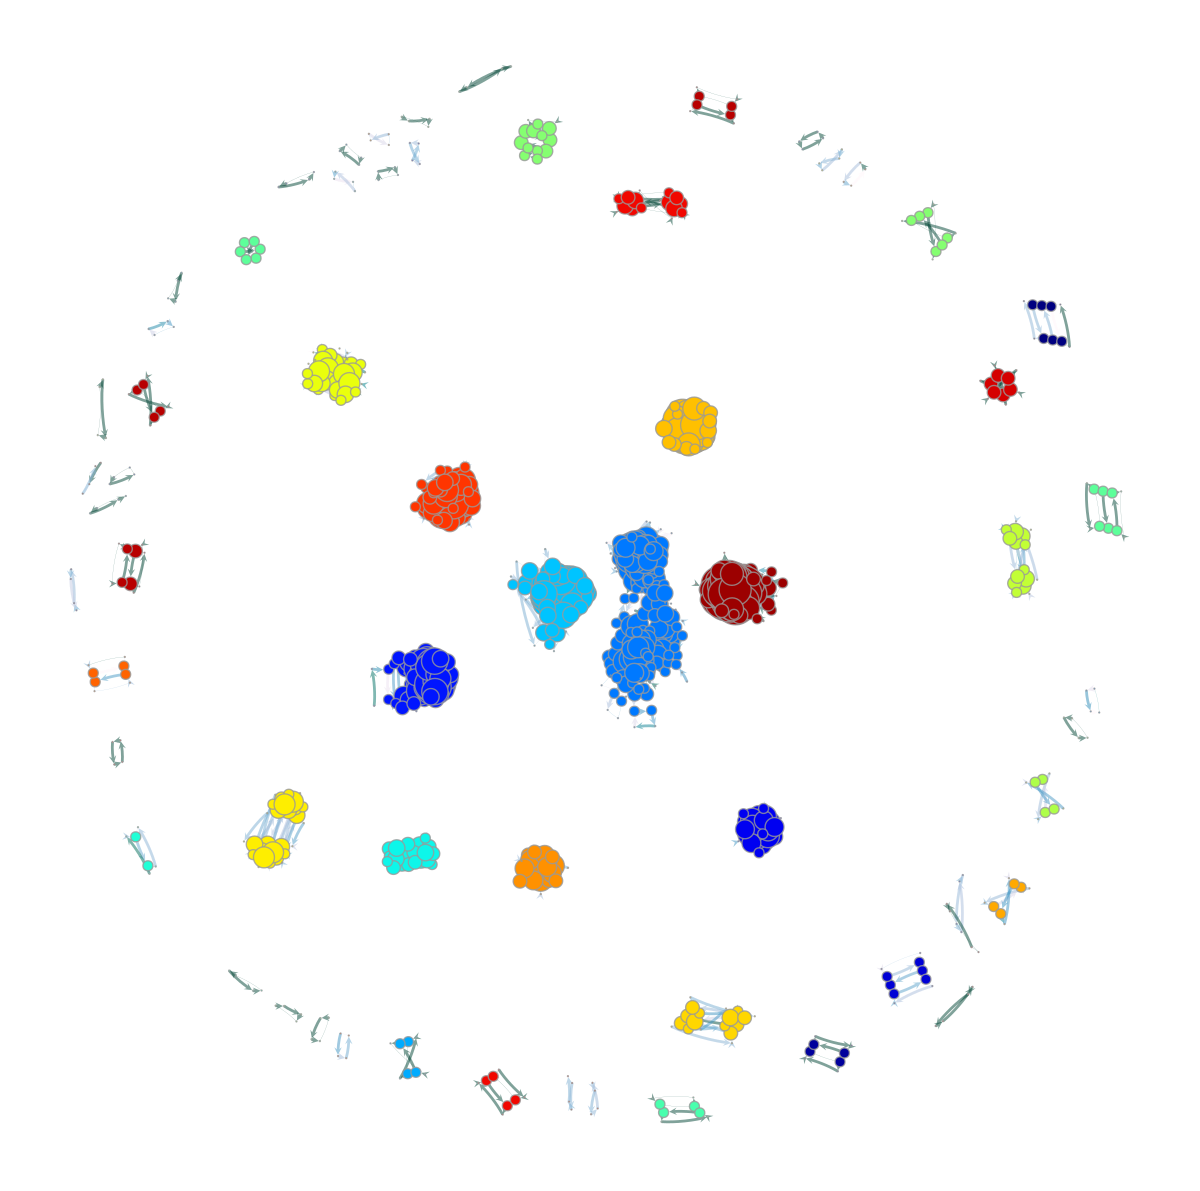

In [78]:
plot_network(rn.graph);

You'll notice that at this stage, the reaction network graph is a collection of "sub"-networks, i.e. a collection of smaller reaction networks for smaller chemical subsystems. This configuration will change once we set up for pathfinding in the next section.

The second way to plot graphs is to use graphistry, which requires setting up an account on Graphistry Hub: https://hub.graphistry.com/. This will not be covered in this demo notebook.

In [79]:
#plot_network_on_graphistry(rn.graph)

### Solving for reaction pathways

To solve for reaction pathways, we must first set the starting point (precursor phases) and ending point (target) phase. 

This will automatically build all the required "zero-cost" edges which connect the different chemical subsystems. Please see the original manuscript for more detail with regards to how this works. In short, zero-cost edges are drawn between and product node to any reactant node that contains a subset of the set consisting of the {precursors + products} phases. 

In [12]:
rn.set_precursors(["Li2CO3", "Mn2O3", "YCl3"])

In [13]:
rn.set_target("YMnO3")

We can see how this changes the network by re-drawing it:

In [68]:
plot_network(rn.graph);

AttributeError: 'rustworkx.PyDiGraph' object has no attribute 'ep'

You should now see that the chemical subsystems have come together -- this is due to the zero-cost edges that were just described. We can now perform pathfinding to extract reaction pathways.

To get reaction pathways, we simply call the `find_pathways()` method. This automatically handles finding pathways to multiple targets, by calling the internal shortest paths method. The _k_ parameter specifies the number of shortest paths to find to each target.

In [33]:
paths = rn.find_pathways(["YMnO3", "LiCl", "CO2"], k=100)

PATHS to YMnO3 

--------------------------------------- 

Mn2O3 + 0.2222 YCl3 -> 0.2222 Mn8Cl3O10 + 0.1111 Y2Mn2O7 (dG = -0.015 eV/atom) 
Mn2O3 + Y2Mn2O7 -> 2 YMnO3 + 2 MnO2 (dG = 0.005 eV/atom) 
Total Cost: 0.528 

Mn2O3 + 0.2222 YCl3 -> 0.2222 Mn8Cl3O10 + 0.1111 Y2Mn2O7 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.038 eV/atom) 
Total Cost: 0.535 

5 Mn2O3 + YCl3 -> Mn8Cl3O10 + YMn2O5 (dG = -0.025 eV/atom) 
YMn2O5 -> YMnO3 + MnO2 (dG = 0.048 eV/atom) 
Total Cost: 0.535 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
Li2O + 0.6667 YCl3 -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.724 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
3 YClO + Mn2O3 -> YCl3 + 2 YMnO3 (dG = 0.0 eV/atom) 
Total Cost: 0.744 

Li2CO3 -> Li2O + CO2 (dG = 0.146 eV/atom) 
Li2O + 0.6667 YCl3 -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
Li2O + 0.6667 YCl3 -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Total Cost: 0.475 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Total Cost: 0.479 

Li2CO3 -> Li2O + CO2 (dG = 0.146 eV/atom) 
Li2O + 0.6667 YCl3 -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Total Cost: 0.504 

Li2CO3 -> Li2O + CO2 (dG = 0.146 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Total Cost: 0.508 

Li2CO3 + 0.5 Mn2O3 -> Li2MnCO4 + 0.25 O2 (dG = 0.054 eV/atom) 
O2 + 4 Li2MnCO4 -> 4 LiMnCO4 + 2 Li2O (dG = -0.026 eV/atom) 
Li2O + 0.6667 YCl3 -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Total Cost: 0.74 

3 Li2CO3 + Mn2O3 -> Li4CO4 + 2 LiMnCO4 (dG = 0.012 eV/atom) 
Li4CO4 -> Li2CO3 + Li2O (dG = 0.024 eV/atom) 
Li2O + 0.6667 YCl3 -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Total Cost: 0.741 

Li2CO3 + 0.5 Mn2O3 -> Li2MnCO4 + 0.25 O2 (dG = 0.054 eV/atom) 
O2 + 4 Li2MnCO4

Li2CO3 + Mn2O3 -> CO2 + 2 LiMnO2 (dG = 0.009 eV/atom) 
Total Cost: 0.267 

2 Li2CO3 -> CO2 + Li4CO4 (dG = 0.055 eV/atom) 
Total Cost: 0.278 

Li2CO3 -> Li2O + CO2 (dG = 0.146 eV/atom) 
Total Cost: 0.301 

Li2CO3 + 0.5 Mn2O3 -> Li2MnCO4 + 0.25 O2 (dG = 0.054 eV/atom) 
Li2MnCO4 + 0.5 O2 -> CO2 + Li2MnO3 (dG = -0.092 eV/atom) 
Total Cost: 0.522 

Li2CO3 + Mn2O3 -> LiCO2 + LiMn2O4 (dG = 0.046 eV/atom) 
1.5 LiCO2 + 0.5 LiMn2O4 -> Li2MnCO4 + 0.5 CO2 (dG = -0.069 eV/atom) 
Total Cost: 0.525 

3 Li2CO3 + Mn2O3 -> Li4CO4 + 2 LiMnCO4 (dG = 0.012 eV/atom) 
Li4CO4 + 2 Mn2O3 -> CO2 + 4 LiMnO2 (dG = -0.025 eV/atom) 
Total Cost: 0.527 

Li2CO3 + Mn2O3 -> Li2MnCO4 + MnO2 (dG = 0.027 eV/atom) 
Li2MnCO4 + 3 MnO2 -> 2 LiMn2O4 + CO2 (dG = -0.039 eV/atom) 
Total Cost: 0.527 

2 Mn2O3 -> Mn3O4 + MnO2 (dG = 0.015 eV/atom) 
Li2CO3 + MnO2 -> CO2 + Li2MnO3 (dG = -0.022 eV/atom) 
Total Cost: 0.528 

Li2CO3 + 1.5 Mn2O3 -> 0.5 Li2Mn2C2O7 + LiMn2O4 (dG = 0.009 eV/atom) 
0.5 Li2CO3 + 0.5 Li2Mn2C2O7 -> Li2MnCO4 + 0.5

In [34]:
from rustworkx.visualization import graphviz_draw

In [38]:
import pyintergraph

In [40]:
import networkx as nx

In [45]:
a = nx.DiGraph()

In [52]:
rn.graph.nodes()

[Reactants: C7Cl8,
 Products: C,Cl2,
 Reactants: C,Cl2,
 Products: C7Cl8,
 Products: C5Cl4,Cl2,
 Reactants: C5Cl4,Cl2,
 Reactants: C5Cl4,
 Products: C,C7Cl8,
 Reactants: C,C7Cl8,
 Products: C5Cl4,
 Reactants: MnCl2,
 Products: Cl2,Mn,
 Reactants: Cl2,Mn,
 Products: MnCl2,
 Reactants: YClO,
 Products: Y2O3,YCl3,
 Reactants: Y2O3,YCl3,
 Products: YClO,
 Reactants: Cl2,YClO,
 Products: O2,YCl3,
 Reactants: O2,YCl3,
 Products: Cl2,YClO,
 Reactants: O2,YClO,
 Products: Cl2,Y2O3,
 Reactants: Cl2,Y2O3,
 Products: O2,YClO,
 Reactants: LiCl,
 Products: Cl2,Li,
 Reactants: Cl2,Li,
 Products: LiCl,
 Reactants: Y2O3,
 Products: O2,Y,
 Reactants: O2,Y,
 Products: Y2O3,
 Reactants: CO2,
 Products: C,O2,
 Reactants: C,O2,
 Products: CO2,
 Reactants: YCl3,
 Products: Cl2,Y,
 Reactants: Cl2,Y,
 Products: YCl3,
 Reactants: Li2O,
 Products: Li,O2,
 Reactants: Li,O2,
 Products: Li2O,
 Reactants: LiC,
 Products: C,Li,
 Reactants: C,Li,
 Products: LiC,
 Products: Li,LiC12,
 Reactants: Li,LiC12,
 Reactants: 

In [63]:
from rustworkx.visualization import mpl_draw

In [64]:
from rustworkx import Pos2DMapping

In [74]:
node_names =[e.chemsys for e in rn.graph.nodes()]

In [78]:
import numpy as np
import matplotlib

In [80]:
color_func_v = _get_cmap_string("jet", domain=sorted(node_names))
vertex_colors = [color_func_v(chemsys) for chemsys in node_names]

In [73]:
def _get_cmap_string(palette, domain):
    """
    Utility function for getting a matplotlib colormap string for a given palette and
    domain.
    """
    domain_unique = np.unique(domain)
    hash_table = {key: i_str for i_str, key in enumerate(domain_unique)}
    mpl_cmap = matplotlib.cm.get_cmap(palette, lut=len(domain_unique))

    def cmap_out(X, **kwargs):
        return mpl_cmap(hash_table[X], **kwargs)

    return cmap_out


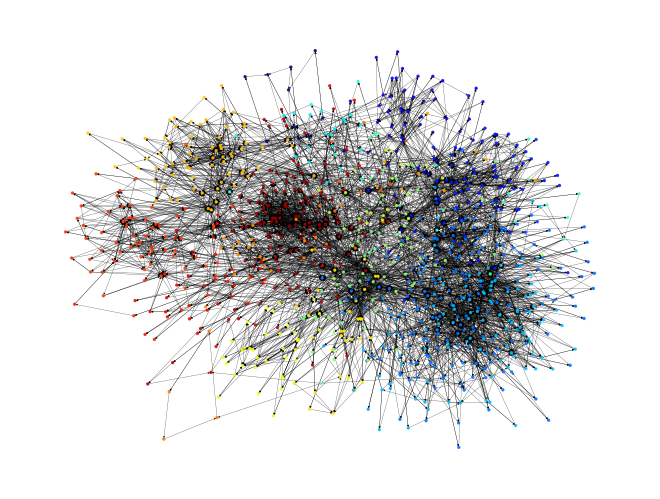

In [87]:
plot_network(rn.graph)

In [92]:
import rustworkx as rx

rn.graph.write_edge_list("test.txt")

In [95]:
list(rn.graph.node_indexes())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [112]:
list(rn.graph.edge_list())

[autoreload of rxn_network.network.network failed: Traceback (most recent call last):
  File "/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/mcdermott/PycharmProjects/reaction-netwo

[(0, 1),
 (2, 3),
 (0, 4),
 (5, 3),
 (6, 7),
 (8, 9),
 (6, 1),
 (2, 9),
 (10, 11),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19),
 (20, 21),
 (22, 23),
 (24, 25),
 (24, 19),
 (20, 23),
 (26, 27),
 (28, 29),
 (30, 31),
 (32, 33),
 (34, 35),
 (36, 37),
 (38, 39),
 (40, 41),
 (42, 43),
 (44, 45),
 (46, 47),
 (48, 49),
 (46, 50),
 (51, 49),
 (52, 47),
 (48, 53),
 (52, 54),
 (55, 53),
 (56, 57),
 (58, 59),
 (60, 61),
 (62, 63),
 (60, 64),
 (65, 63),
 (60, 66),
 (67, 63),
 (68, 69),
 (70, 71),
 (68, 66),
 (67, 71),
 (68, 72),
 (73, 71),
 (74, 75),
 (76, 77),
 (74, 69),
 (70, 77),
 (74, 61),
 (62, 77),
 (74, 66),
 (67, 77),
 (78, 79),
 (80, 81),
 (78, 82),
 (83, 81),
 (78, 84),
 (85, 81),
 (78, 86),
 (87, 81),
 (78, 88),
 (89, 81),
 (78, 90),
 (91, 81),
 (92, 82),
 (83, 93),
 (92, 84),
 (85, 93),
 (94, 95),
 (96, 97),
 (94, 79),
 (80, 97),
 (94, 84),
 (85, 97),
 (94, 88),
 (89, 97),
 (94, 90),
 (91, 97),
 (98, 95),
 (96, 99),
 (98, 79),
 (80, 99),
 (98, 88),
 (89, 99),
 (98, 100),
 (101, 99),
 (

In [59]:
weighted_edge_list = []
for start_idx, end_idx, obj in rn.graph.weighted_edge_list():
    start_node = rn.graph.get_node_data(start_idx)
    end_node = rn.graph.get_node_data(end_idx)
    weighted_edge_list.append((start_node, end_node, {"obj":obj}))

In [60]:
a.add_edges_from(weighted_edge_list)

In [47]:
a.add_weighted_edges_from(zip(rn.graph.edges(), rn.graph.edge_list()))

ValueError: not enough values to unpack (expected 3, got 2)

The output of this method is a `PathwaySet` object containing a set of `BasicPathway` objects. Note that these objects contain a list of reactions and associated costs, but the actual pathway is typically not balanced (i.e. some intermediates are made and never consumed).

In [133]:
example_path = paths.get_paths()[0]
print(example_path)

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
Li2O + 0.6667 YCl3 -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.724


This means that the reactions you see above do not necessarily include all reactants, nor do they include form all desired products. They are simply a series of reactions extracted from the reaction network that may be encountered as the system attempts to get from precursor phases to target phases.

To actually get balanced reaction pathways, we can use the `PathwaySolver` class. This class takes a `PathwaySet`, the set of entries used in the reaction network, and a cost function, and can be used to solve for balanced pathways given a net reaction. First we initialize the class:

In [134]:
ps = PathwaySolver(paths, rn.entries, cf)

To balance the pathways, we must provide a net reaction representing the total conversion of precursors to final products. This corresponds to the assisted metathesis reaction we defined in the beginning. We can make this reaction by initializing a `ComputedReaction` object from the corresponding entries:

In [135]:
product_entries = []
for i in ["YMnO3","LiCl","CO2"]:
    product_entries.append(rn.entries.get_min_entry_by_formula(i))
    
net_rxn = ComputedReaction.balance(rn.precursors, product_entries)
net_rxn

1.5 Li2CO3 + YCl3 + 0.5 Mn2O3 -> YMnO3 + 3 LiCl + 1.5 CO2

Finally, we provide the net reaction to the `PathwaySolver` object. Note that the _intermediate_rxn_energy_cutoff_ helps to limit which intermediate reactions are considered (this can substantially decrease the combinatorial complexity), and the _filter_interdependent_ flag verifies that suggested pathways do not contain interdependent reactions (i.e. where both the reactants of reaction A depend on the products of the reaction B, and the reactants of reaction B depend on the products of reaction A).

**Note: Even though much of the computation step has been optimized / parallelized, this is often the most time-intensive step in the reaction network analysis. Consider limiting the value of the maximum number of combos to 5 or less, as well as the value of the intermediate reaction energy cutoff (i.e. < 0.0).**

In [136]:
balanced_paths = ps.solve(net_rxn, max_num_combos=4, 
                          intermediate_rxn_energy_cutoff=0.0, 
                          use_minimize_enumerator=False,
                          filter_interdependent=True)

PathwaySolver (Batch 1/1):   0%|                                                                         | 0/4 [00:00<?, ?it/s](_get_balanced_paths_ray pid=54244) OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
(_get_balanced_paths_ray pid=54239) OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
(_get_balanced_paths_ray pid=54243) OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
(_get_balanced_paths_ray pid=54236) OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
PathwaySolver (Batch 1/1): 100%|█████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.94s/it]


We can now print the suggested, balanced reaction pathways:

In [137]:
for idx, path in enumerate(balanced_paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

0.6667 YCl3 + Li2O -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
Average Cost: 0.252


Path 2 

YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
0.5 Mn2O3 + 0.5 Li2CO3 -> 0.5 CO2 + LiMnO2 (dG = 0.009 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.081 eV/atom) 
Average Cost: 0.256


Path 3 

0.6667 YCl3 + Li2O -> 0.3333 Y2O3 + 2 LiCl (dG = -0.297 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
YCl3 + 1.5 Li2O -> 0.5 Y2O3 + 3 LiCl (dG = -0.297 eV/atom) 
Average Cost: 0.257


Path 4 

Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
2 YClO + Li2O -> Y2O3 + 2 LiCl (dG = -0.136 eV/atom) 
Average Cost: 0.257


Path 5 

Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/ato

We note that **Pathway 1 most closely matches the experimentally observed reaction pathway** (ordering subject to change in the future).

Often times however, the suggested pathways will include hypothetical (never-before-synthesized) materials (e.g., Li3MnO3). Thus it is important to note that the top-ranked pathway may not necessarily match what is experimentally observed; if a certain phase is not accessible (perhaps due to kinetic reasons), this may effectively rule out a top pathway from being physically possible.

### Running networks with jobflow

As was demonstrated in the previous notebook on reaction enumeration, the _reaction-network_ package includes workflows implemented using _jobflow_. 

Below we will briefly demonstrate constructing and running the same analysis as above using the `NetworkFlowMaker`. Reminder: you must have properly configured your jobflow settings in order for this to work. Read more here: https://materialsproject.github.io/jobflow/

In [112]:
from rxn_network.flows.core import NetworkFlowMaker
from rxn_network.jobs.core import NetworkMaker, PathwaySolverMaker
from jobflow.managers.local import run_locally

In [113]:
precursors=["YCl3", "Mn2O3", "Li2CO3"]
targets=["YMnO3", "LiCl", "CO2"]
k=4
temp = 650+273
cf = Softplus(temp)

network_maker = NetworkMaker(cost_function=cf, precursors=precursors, targets=targets, calculate_pathways=k)
solver_maker = PathwaySolverMaker(cost_function=cf, precursors=precursors, targets=targets)

In [114]:
flow = NetworkFlowMaker(network_maker=network_maker, 
                        solver_maker=solver_maker, 
                        use_minimize_enumerators=False).make(precursors=precursors, 
                                                             targets=targets, 
                                                             entries=entry_set)

<module 'matplotlib.pyplot' from '/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/matplotlib/pyplot.py'>

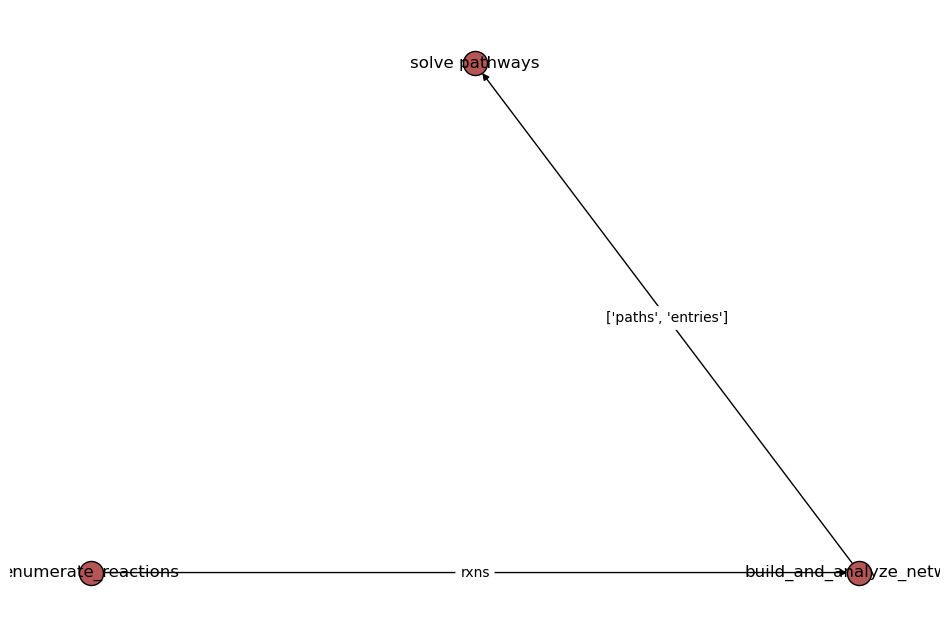

In [115]:
flow.draw_graph()

In [116]:
output = run_locally(flow)

2022-10-20 16:14:03,507 INFO Started executing jobs locally


INFO:jobflow.managers.local:Started executing jobs locally


2022-10-20 16:14:03,520 INFO Starting job - enumerate_reactions (8ac6607a-38af-487e-b723-2ee2d799d340)


INFO:jobflow.core.job:Starting job - enumerate_reactions (8ac6607a-38af-487e-b723-2ee2d799d340)


2022-10-20 16:14:03,533 INFO rxn_network.jobs.core Running enumerators...


INFO:rxn_network.jobs.core:Running enumerators...


2022-10-20 16:14:03,535 INFO rxn_network.jobs.utils Running BasicEnumerator


INFO:rxn_network.jobs.utils:Running BasicEnumerator
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:04<00:00, 11.36it/s]

2022-10-20 16:14:08,359 INFO rxn_network.jobs.utils Adding 2182 reactions to reaction set



INFO:rxn_network.jobs.utils:Adding 2182 reactions to reaction set


2022-10-20 16:14:08,360 INFO rxn_network.jobs.utils Completed reaction enumeration. Filtering duplicates...


INFO:rxn_network.jobs.utils:Completed reaction enumeration. Filtering duplicates...


2022-10-20 16:14:08,379 INFO rxn_network.jobs.core Building task document...


INFO:rxn_network.jobs.core:Building task document...


2022-10-20 16:14:09,005 INFO Finished job - enumerate_reactions (8ac6607a-38af-487e-b723-2ee2d799d340)


INFO:jobflow.core.job:Finished job - enumerate_reactions (8ac6607a-38af-487e-b723-2ee2d799d340)


2022-10-20 16:14:09,007 INFO Starting job - build_and_analyze_network (d6d9f12f-0ed3-4e72-9617-a65b533df1dc)


INFO:jobflow.core.job:Starting job - build_and_analyze_network (d6d9f12f-0ed3-4e72-9617-a65b533df1dc)
INFO:ReactionNetwork:Building graph from reactions...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2182/2182 [00:01<00:00, 1261.50it/s]


PATHS to YMnO3 

--------------------------------------- 

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
Y2Mn2O7 + Mn2O3 -> 2 MnO2 + 2 YMnO3 (dG = 0.005 eV/atom) 
Total Cost: 0.516 

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.038 eV/atom) 
Total Cost: 0.524 

5 Mn2O3 + YCl3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> MnO2 + YMnO3 (dG = 0.048 eV/atom) 
Total Cost: 0.524 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.297 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.708 

PATHS to LiCl 

--------------------------------------- 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.297 eV/atom) 
Total Cost: 0.464 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.029 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Total Cost: 0.469 

Li2CO3 -> 

INFO:jobflow.core.job:Finished job - build_and_analyze_network (d6d9f12f-0ed3-4e72-9617-a65b533df1dc)


2022-10-20 16:14:17,782 INFO Starting job - solve pathways (48c4baf2-e03d-4ebb-851f-e628af51dccf)


INFO:jobflow.core.job:Starting job - solve pathways (48c4baf2-e03d-4ebb-851f-e628af51dccf)
INFO:PathwaySolver:Net reaction: YCl3 + 0.5 Mn2O3 + 1.5 Li2CO3 -> YMnO3 + 3 LiCl + 1.5 CO2 

INFO:PathwaySolver:Identifying reactions between intermediates...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 91.91it/s]
INFO:PathwaySolver:Found 34 intermediate reactions! 

PathwaySolver (Batch 1/1): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]

2022-10-20 16:14:22,016 INFO Finished job - solve pathways (48c4baf2-e03d-4ebb-851f-e628af51dccf)



INFO:jobflow.core.job:Finished job - solve pathways (48c4baf2-e03d-4ebb-851f-e628af51dccf)


2022-10-20 16:14:22,017 INFO Finished executing jobs locally


INFO:jobflow.managers.local:Finished executing jobs locally


Finally, the output from the flow can be accessed as follows:

In [117]:
paths = output[flow.job_uuids[-1]][1].output.balanced_paths

In [118]:
for idx, path in enumerate(balanced_paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
Mn2O3 + Li2CO3 -> CO2 + 2 LiMnO2 (dG = 0.009 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.081 eV/atom) 
Average Cost: 0.254


Path 2 

Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
YCl3 + Li2O -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
2 YClO + Li2O -> Y2O3 + 2 LiCl (dG = -0.136 eV/atom) 
Average Cost: 0.257


Path 3 

2 YCl3 + 3 Li2O -> Y2O3 + 6 LiCl (dG = -0.297 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
Average Cost: 0.271




### Thank you!

We hope this notebook was helpful in introducing the `ReactionNetwork` class found in the _reaction-network_ package. If any significant errors are encountered, please first double-check that your settings are configured properly (e.g., proper installation of all dependencies, acquisition of a Materials Project API key, etc.). 

If the error persists, then please raise an Issue here: https://github.com/GENESIS-EFRC/reaction-network/issues